### Importing all necessary packages

In [4]:
import glob
import os
import sklearn.mixture
import sys
import opensmile
import audiofile
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xlwt import Workbook

### Importing OpenSmile package

In [6]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

### Extracting all the 88 features using open smile

In [7]:
class DataPrep:
    def __init__(self, folderPath=None):

        self.folderPath = folderPath
        self.spk_files = os.listdir(self.folderPath)

        self.file_features = np.zeros((1,88))
        Y=[0]
        
        for spk_file in range(len(self.spk_files)):
            wav_path = os.path.join(self.folderPath,self.spk_files[spk_file])
            y = smile.process_file(wav_path)
            file_feats = np.asarray(y)
            self.file_features = np.concatenate((self.file_features, file_feats),axis=0)
            label = self.folderPath
            label=label[-8]
            if label=='f':
                l=0
            else:
                l=1
            Y.append(l)

        self.file_features = self.file_features[1:,:]
        self.labels=np.asarray(Y)
        self.labels=self.labels.T
        self.labels = self.labels[1:]

#### Taking data from dataset which are separated as train and test data properly

In [8]:
#we have to pass correct folder paths in DataPrep to take test and train data

#extracting training data
#Train_dataF means data which is fake speech
#Train_dataO means data which is original speech
Train_dataF = DataPrep(r'C:\Users\HP\Desktop\Dataset\data\251\Train\fake_slt')
Train_dataO = DataPrep(r'C:\Users\HP\Desktop\Dataset\data\251\Train\orig_slt')

#extracting testing data
#Test_dataF means data which is fake speech
#Test_dataF means data which is original speech
Test_dataF = DataPrep(r'C:\Users\HP\Desktop\Dataset\data\251\Test\fake_slt')
Test_dataO = DataPrep(r'C:\Users\HP\Desktop\Dataset\data\251\Test\orig_slt')

#### Dividing Train Data accordingly

In [9]:
#Dividing train data as X_trainF, Y_trainF, X_trainO and Y_trainO
#X_trainF means features extracted from fake speech
#X_trainO means features extracted from original speech

X_trainF=Train_dataF.file_features
Y_trainF=Train_dataF.labels
X_trainO=Train_dataO.file_features
Y_trainO=Train_dataO.labels

#### Checking size of X_trainF, Y_trainF, X_trainO and Y_trainO

In [10]:
print(np.shape(X_trainF))
print(np.shape(X_trainO))
print(np.shape(Y_trainF))
print(np.shape(Y_trainO))

(192, 88)
(192, 88)
(192,)
(192,)


#### Dividing Test Data accordingly

In [11]:
#Dividing test data as X_testF, Y_testF, X_testO and Y_testO
#X_testF means features extracted from fake speech
#X_testO means features extracted from original speech

X_testF=Test_dataF.file_features
Y_testF=Test_dataF.labels
X_testO=Test_dataO.file_features
Y_testO=Test_dataO.labels

#### Checking size of X_testF, Y_testF, X_testO and Y_testO

In [12]:
print(np.shape(X_testF))
print(np.shape(X_testO))
print(np.shape(Y_testF))
print(np.shape(Y_testO))

(21, 88)
(21, 88)
(21,)
(21,)


#### Concatenate Fake and Non-fake speech (Train)

In [13]:
X=np.concatenate((X_trainF, X_trainO),axis=0)
y=np.concatenate((Y_trainF, Y_trainO),axis=0)

print(np.shape(X))
print(np.shape(y))

(384, 88)
(384,)


##### This step of train-test split done to do shuffle the data. The splitted test from the train_test_split was not used for testing. Testing was done from the testing set seperated earlier only

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, shuffle=True, random_state=0)

### Concatanate Fake and Non-fake speech (Test)

In [15]:
X_test=np.concatenate((X_testF, X_testO),axis=0)
y_test=np.concatenate((Y_testF, Y_testO),axis=0)

print(np.shape(X_test))
print(np.shape(y_test))

(42, 88)
(42,)


##### Remove NaN(Not a Number) from train

In [16]:
X_train1=X_train[~np.isnan(X_train).any(axis=1)]
nan_index=np.argwhere(np.isnan(X_train))

removal_rows=np.unique(nan_index[:,0])
y_train1=np.delete(y_train,removal_rows,axis=0)

X_train=X_train1
y_train=y_train1

##### Remove NaN(Not a Number) from test

In [17]:
X_test1=X_test[~np.isnan(X_test).any(axis=1)]
nan_index=np.argwhere(np.isnan(X_test))

removal_rows=np.unique(nan_index[:,0])
y_test1=np.delete(y_test,removal_rows,axis=0)

X_test=X_test1
y_test=y_test1

##### Checking NaN after removing

In [18]:
print(np.sum(np.isnan((X_train))))
print(np.sum(np.isnan((X_test))))

0
0


### Feature selection

In [19]:
etc=ExtraTreesClassifier(n_estimators=50)
etc=etc.fit(X_train, y_train)

#### Finding the threshold

In [20]:
#th=-np.sort(-etc.feature_importances_)[No. of features]
#th is threshold

th=-np.sort(-etc.feature_importances_)[5]
th

0.016110392976496

#### Indexes of top n features

In [21]:
res = [idx for idx, val in enumerate(etc.feature_importances_) if val > th]
res=np.asarray(res)
res.T

array([62, 63, 76, 77, 78])

#### Picking the features according to the selected index

In [22]:
X_train_new=(X_train[:,res])
X_test_new=X_test[:,res]

##### Checking shape of X_train_new and X_test_new

In [23]:
print(np.shape(X_train_new))
print(np.shape(X_test_new))

(383, 5)
(42, 5)


### Random Forest

In [55]:
pipe1 = Pipeline([ ('std', StandardScaler()), ('Random_forest', RandomForestClassifier(n_estimators = 100))], verbose = True)
pipe1.fit(X_train_new, y_train)
prob_score_RF=pipe1.predict_proba(X_test_new)
print("\nAccuracy:",accuracy_score(y_test, pipe1.predict(X_test_new)))
print("\n----------------Classification Report----------------\n\n",classification_report(y_test,pipe1.predict(X_test_new)))


[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.1s

Accuracy: 0.8809523809523809

----------------Classification Report----------------

               precision    recall  f1-score   support

           0       0.81      1.00      0.89        21
           1       1.00      0.76      0.86        21

    accuracy                           0.88        42
   macro avg       0.90      0.88      0.88        42
weighted avg       0.90      0.88      0.88        42



#### Confusion Matrix for Random Forest

In [25]:
print(sklearn.metrics.confusion_matrix(y_test, pipe1.predict(X_test_new)))

[[21  0]
 [ 5 16]]


### Decision tree

In [54]:
pipe2 = Pipeline([ ('std', StandardScaler()), ('decision_tree', DecisionTreeClassifier())], verbose = True)
pipe2.fit(X_train_new, y_train)
prob_score_DT=pipe2.predict_proba(X_test_new)
print("\nAccuracy:",accuracy_score(y_test, pipe2.predict(X_test_new)))
print("\n----------------Classification Report----------------\n\n",classification_report(y_test,pipe2.predict(X_test_new)))

[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing decision_tree, total=   0.0s

Accuracy: 0.8333333333333334

----------------Classification Report----------------

               precision    recall  f1-score   support

           0       0.75      1.00      0.86        21
           1       1.00      0.67      0.80        21

    accuracy                           0.83        42
   macro avg       0.88      0.83      0.83        42
weighted avg       0.88      0.83      0.83        42



#### Confusion Matrix for Decision Tree

In [35]:
print(sklearn.metrics.confusion_matrix(y_test, pipe2.predict(X_test_new)))

[[21  0]
 [ 7 14]]


### SVM (Support Vector Machine)

In [52]:
pipe4 = Pipeline([ ('std', StandardScaler()), ('SVM', SVC(kernel='linear',probability=True) )], verbose = True)
pipe4.fit(X_train_new, y_train)
prob_score_SVM=pipe4.predict_proba(X_test_new)
print("\nAccuracy:",accuracy_score(y_test, pipe4.predict(X_test_new)))
print("\n----------------Classification Report----------------\n\n",classification_report(y_test,pipe4.predict(X_test_new)))

[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing SVM, total=   0.0s

Accuracy: 0.8571428571428571

----------------Classification Report----------------

               precision    recall  f1-score   support

           0       0.78      1.00      0.88        21
           1       1.00      0.71      0.83        21

    accuracy                           0.86        42
   macro avg       0.89      0.86      0.85        42
weighted avg       0.89      0.86      0.85        42



#### Confusion matrix for SVM

In [29]:
print(sklearn.metrics.confusion_matrix(y_test, pipe4.predict(X_test_new)))

[[21  0]
 [ 6 15]]


### Logistic regression

In [53]:
pipe5 = Pipeline([ ('std', StandardScaler()), ('Logistic_Regression', LogisticRegression(random_state = 0) )], verbose = True)
pipe5.fit(X_train_new, y_train)
prob_score_LR=pipe5.predict_proba(X_test_new)
print("\nAccuracy:",accuracy_score(y_test, pipe5.predict(X_test_new)))
print("\n----------------Classification Report----------------\n\n",classification_report(y_test,pipe5.predict(X_test_new)))

[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline]  (step 2 of 2) Processing Logistic_Regression, total=   0.0s

Accuracy: 0.8571428571428571

----------------Classification Report----------------

               precision    recall  f1-score   support

           0       0.78      1.00      0.88        21
           1       1.00      0.71      0.83        21

    accuracy                           0.86        42
   macro avg       0.89      0.86      0.85        42
weighted avg       0.89      0.86      0.85        42



#### Confusion matrix for Logistic regression

In [37]:
print(sklearn.metrics.confusion_matrix(y_test, pipe5.predict(X_test_new)))

[[21  0]
 [ 6 15]]


### Probability Score Combination of ML models

In [57]:
#Here we do probability score combination, such that different weightages are given to each ML model.
#Where all weightages add up to 1.
#Here a:%RF, b:%DT, c:%SVM and d:%LR
#output will be given in excel sheet
#wb.save("filename-to-be-given.xls")

wb = Workbook()
sheet1 = wb.add_sheet('Sheet 1')
value = 10
count = 0
sheet1.write(count,0,"%RF")
sheet1.write(count,1,"%DT")
sheet1.write(count,2,"%SVM")
sheet1.write(count,3,"%LR")
sheet1.write(count,4,"Accuracy")
for a in range(value+1):
    for b in range(value+1):
        for c in range(value+1):
            for d in range(value+1):
                if (a+b+c+d) == value:
                    y_pred = []
                    for i in range(len(y_test)):
                        score_0 = (a*prob_score_RF[i][0])+(b*prob_score_DT[i][0])+(c*prob_score_SVM[i][0])+(d*prob_score_LR[i][0])
                        score_1 = (a*prob_score_RF[i][1])+(b*prob_score_DT[i][1])+(c*prob_score_SVM[i][1])+(d*prob_score_LR[i][1])
                        if score_0 > score_1:
                            y_pred.append(0)
                        else:
                            y_pred.append(1)
                    sheet1.write(count+1,0,a/value)
                    sheet1.write(count+1,1,b/value)
                    sheet1.write(count+1,2,c/value)
                    sheet1.write(count+1,3,d/value)
                    sheet1.write(count+1,4,accuracy_score(y_test,y_pred))
                    count = count + 1
wb.save("LibreTTS-251.xls")                    

### Bar graph for most repeated top five features

[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.1s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.1s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.1s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.1s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.1s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.1s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.1s
[Pipel

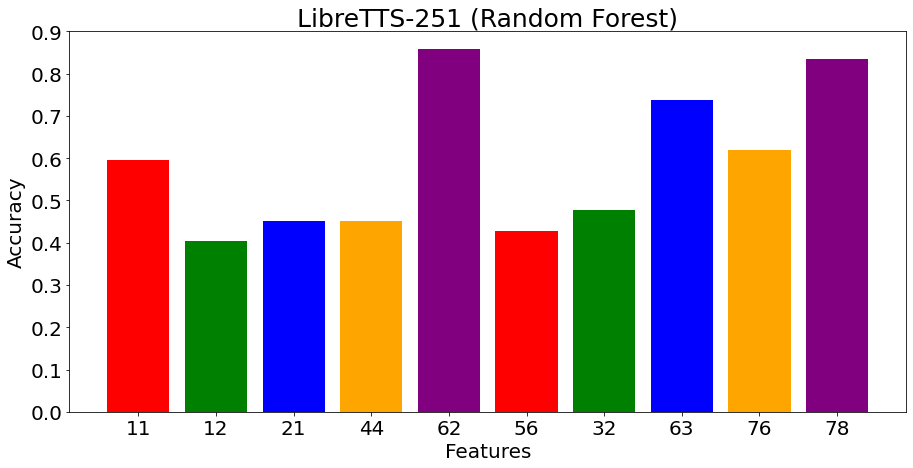

In [60]:
#Most repeated top five features are: 11, 12, 21, 44, 62, 56, 32, 63, 76 and 78

X_axis = ['11', '12', '21', '44', '62', '56', '32', '63', '76', '78']
Y_axis = []

pipe10 = Pipeline([ ('std', StandardScaler()), ('Random_forest', RandomForestClassifier(n_estimators = 100))], verbose = True)
features = [11, 12, 21, 44, 62, 56, 32, 63, 76, 78]
for i in features:
    X_new = X_train[:,[i]]
    pipe10.fit(X_new, y_train)
    X_t_new = X_test[:,[i]]
    Y_axis.append(accuracy_score(y_test, pipe10.predict(X_t_new)))

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
plt.title("LibreTTS-251 (Random Forest)",fontdict={'fontsize': 25})
plt.xlabel("Features",fontdict={'fontsize': 20})
plt.ylabel("Accuracy",fontdict={'fontsize': 20})
plt.bar(X_axis,Y_axis,color=[ 'red', 'green', 'blue', 'orange','purple'])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()